In [1]:
import helper
from helper import *
import importlib
importlib.reload(helper)

df = load_merged_data(drop_na=True)

# Übersicht

In diesem Notebook werden zwei Konzepte betrachtet und ausgearbeitet, die für alle folgenden Notebooks relevant sind: Cross Validation und Model Evaluation.

## Cross Validation

Um Modelle bewerten zu können, müssen Daten in Trainings- und Testdaten aufgeteilt werden. So kann man die Evaluation des Modells auf neuen Daten durchführen. Im einfachsten Fall werden die Daten einmal geteilt und ein Teil für das Training und der andere Teil zum Testen verwendet. Ein verbesserter Ansatz ist die Cross Validation (CV), bei der die Daten mehrfach geteilt werden. In dieser Arbeit wird daher CV verwendet.

In jedem Fall stellt sich die Frage, wie die Daten sinnvoll aufgeteilt werden. Bei einfachen Datensätzen, bei denen es keine Abhängigkeiten zwischen den einzelnen Datenpunkten gibt, kann man den Datensatz einfach zufällig in `n` gleich große Mengen teilen und anschließend jeweils einen Teil zum Testen verwenden.
Dieser Ansatz ist bei diesem Datensatz ungeeignet, da zeitlich nah beieinanderliegende Datenpunkt in der Regel fast identisch sind, sodass die Trainingsdaten in diesem Fall gar keine neuen Daten für das Modell wären.

Dazu kommt, dass bei Zeitreihen darauf geachtet werden muss, dass zukünftige Daten nicht zum Trainieren verwendet werden. Das bedeutet, dass alle Datenpunkt aus dem Testset aktueller bzw. neuer sein müssen als alle Datenpunkte aus dem Trainingsset. Dies ist wichtig, da das Modell sonst in der Lage wäre, in die Zukunft zu schauen und somit die Performance auf neuen Daten nicht korrekt bewertet werden kann. Wenn dies doch passiert, wird von einem Leaking von Daten gesprochen: Das muss unbedingt vermieden werden.

[Cross Validation in Time Series](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)

Wenn man nicht CV verwendet, kann man einfach die letzten bzw. neusten x-Prozent zum Testen und den Rest der Daten zum Trainieren verwendet. Dadurch wird verhindert, dass neue Daten in die Trainingsdaten leaken. Für CV ist in Python bereits `TimeSeriesSplit` implementiert. Dieser Splitter stellt sicher, dass das Leaken von Trainingsdaten unterbunden wird.

Im Fall von diesem Datensatz könnte man überlegen, wie problematisch Leaking ist. Die einzelnen Brennvorgänge laufen größtenteils unabhängig, sodass aus Datenpunkten von zukünftigen Brennvorgängen kaum Rückschlüsse auf die Vergangenheit gezogen werden können. Allerdings beeinflussen zum Beispiel Rußablagerungen auch zukünftige Brennvorgänge, sodass es doch zu Leaking kommen kann. Die Signifikanz dieses Einflusses ist jedoch unbekannt. Daher wird in dieser Arbeit `TimeSeriesSplit` verwendet, um Leaking zu verhindern.

In [2]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)


def extract_measures_from_split(train_index, test_index):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
    
    train_min_date = train_df['date'].min()
    train_max_date = train_df['date'].max()
    test_min_date = test_df['date'].min()
    test_max_date = test_df['date'].max()
    
    train_duration = train_max_date - train_min_date
    test_duration = test_max_date - test_min_date
    
    return {
        'train_min_date': train_min_date,
        'train_max_date': train_max_date,
        'test_min_date': test_min_date,
        'test_max_date': test_max_date,
        'train_duration': train_duration,
        'test_duration': test_duration
    }

split_df = pd.DataFrame([extract_measures_from_split(train_index, test_index) for train_index, test_index in tscv.split(df)])

split_df

,train_min_date,train_max_date,test_min_date,test_max_date,train_duration,test_duration
0,2019-11-13 10:32:10,2020-07-17 09:26:10,2020-07-17 09:26:20,2021-03-08 19:53:10,246 days 22:54:00,234 days 10:26:50
1,2019-11-13 10:32:10,2021-03-08 19:53:10,2021-03-08 19:53:20,2021-09-29 09:37:30,481 days 09:21:00,204 days 13:44:10
2,2019-11-13 10:32:10,2021-09-29 09:37:30,2021-09-29 09:37:40,2022-05-15 02:00:10,685 days 23:05:20,227 days 16:22:30
3,2019-11-13 10:32:10,2022-05-15 02:00:10,2022-05-15 02:00:20,2022-11-27 01:35:10,913 days 15:28:00,195 days 23:34:50
4,2019-11-13 10:32:10,2022-11-27 01:35:10,2022-11-27 01:35:20,2023-08-30 23:24:10,1109 days 15:03:00,276 days 21:48:50


## Model Evaluation

Um die Performance von den entwickelten Modellen zu bewerten und mit der Vorhersage des Ofens zu vergleichen, muss eine geeignete Kenngröße gefunden werden. Um einen Einblick in die Daten zu erhalten, wird zunächst die Verteilung der Zielvariable `refuellingTimePointActual` betrachtet:

<Axes: xlabel='month', ylabel='refuellingTimePointActual'>

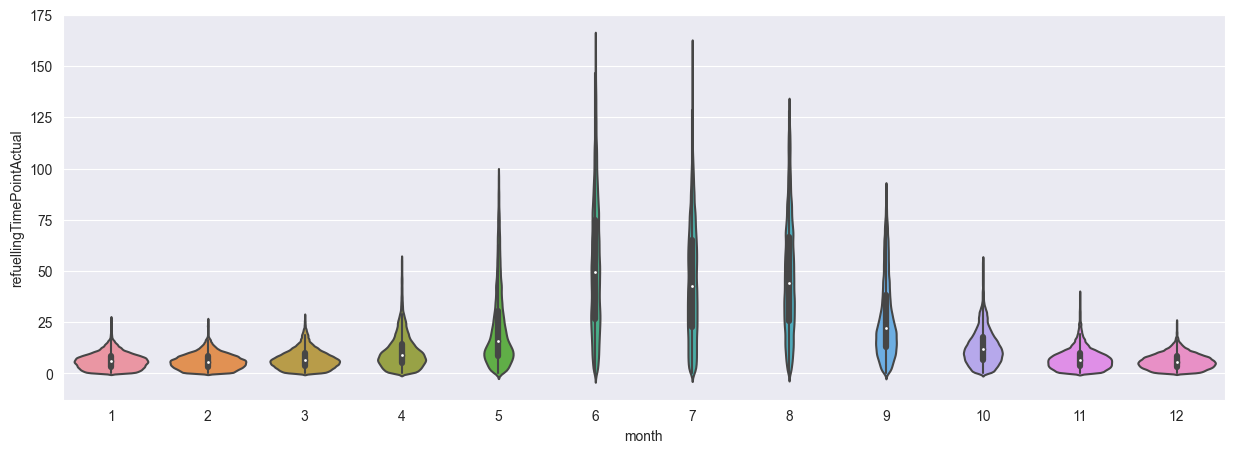

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df['month'] = df['date'].dt.month

fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=df, x="month", y="refuellingTimePointActual", ax=ax)

Auffällig ist die starke Varianz der Zielvariable. In den Wintermonaten werden 20 Stunden selten überschritten, meistens sind es deutlich weniger als 10 Stunden. Im Sommer hingegen sind auch Werte größer als 100 Stunden = 4 Tage möglich.

Am Ende ist ein Modell gewünscht, dass den Nachfüllzeitpunkt berechnet. Wenige Stunden vor dem Nachfüllzustand sollte die Vorhersage daher eine deutlich höhere absolute Genauigkeit haben, als Tage vor dem Nachfüllzustand. Wenn der Nachfüllzustand zum Beispiel nur noch zwei Stunden entfernt ist, ist eine Abweichung von einer Stunde deutlich schlimmer, als wenn der Nachfüllzustand noch zwei Tage entfernt ist.

Würde man nun den MSE verwenden, wäre eine Abweichung von einer Stunde in beiden Fällen gleich schlimm. Daher wird in dieser Arbeit der MAPE (Mean Absolute Percentage Error) verwendet. Dieser ist definiert als:

$$MAPE = \frac{1}{n} \sum_{i=1}^{n-1} \frac{\left|y_i - \hat{y_i}\right|}{max(\epsilon, \left|y_i\right|)}$$

wobei $\epsilon$ als kleiner Wert verwendet wird, um Division durch 0 zu verhindern.

[Mean absolute percentage error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error)

In [4]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

y_actual = df['refuellingTimePointActual']
y_pred = df['refuellingTimePoint']

mape = mean_absolute_percentage_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
print(f'MAPE:  {mape:.2f}')
print(f'MSE:   {mse:.2f}')
print(f'RMSE:  {np.sqrt(mse):.2f}')


MAPE:  0.69
MSE:   143.28
RMSE:  11.97


Um den Unterschied zwischen MSE und MAPE zu verdeutlichen, kann man sich die beiden Metriken für die Monate einzeln anschauen.

Betrachtet man nur den MSE, bzw RMSE, dann ist die Prognose in den Wintermonaten mit einer durchschnittlichen Abweichung von 4 Stunden deutlich besser als die Prognose in den Sommermonaten mit 17 Stunden. Tatsächlich ist es jedoch genau andersherum, da eine Abweichung von 4 Stunden im Winter sehr viel schlimmer ist, als eine Abweichung von 17 Stunden im Sommer. Der MAPE berücksichtigt dies hingegen und ist daher die bessere Metrik für diesen Datensatz und wird im Folgenden verwendet.

In [5]:
# Monate abrufen
months = df['date'].dt.month.unique()

# Monate sortieren
months = np.sort(months)

def calculate_measures_for_month(month):
    y_prediction_month = df[df['date'].dt.month == month]['refuellingTimePoint']
    y_actual_month = df[df['date'].dt.month == month]['refuellingTimePointActual']
    
    # MSE/MAPE berechnen
    mse_month = mean_squared_error(y_actual_month, y_prediction_month)
    mape_month = mean_absolute_percentage_error(y_actual_month, y_prediction_month)
    
    return {
        'month': month,
        'mse': mse_month,
        'rmse': np.sqrt(mse_month),
        'mape': mape_month
    }

month_df = pd.DataFrame([calculate_measures_for_month(month) for month in months])
month_df

,month,mse,rmse,mape
0,1,18.751719,4.330326,1.014429
1,2,12.529085,3.539645,1.041176
2,3,16.225042,4.028032,0.857634
3,4,29.237607,5.407181,0.701970
4,5,141.069671,11.877275,0.513328
5,6,360.922192,18.997952,0.369160
6,7,298.235314,17.269491,0.395058
7,8,253.557656,15.923494,0.316632
8,9,404.792460,20.119455,0.676763
9,10,52.132510,7.220285,0.645895


Der MAPE Wert von `0.69` wird im folgenden als Referenzwert für alle Modelle verwendet. Modelle, die einen höheren MAPE Wert haben, sind schlechter als die naive Vorhersage des Ofens und sollten daher nicht verwendet werden. Modelle mit einem ähnlichen MAPE Wert sind ähnlich gut wie die naive Vorhersage des Ofens und können daher verwendet werden. Sie liefern jedoch keinen Mehrwert. Modelle mit einem niedrigeren MAPE Wert sind besser als die naive Vorhersage des Ofens und sollten daher verwendet werden.

Das Ziel ist es, einen MAPE Wert von unter `0.69` zu erreichen.

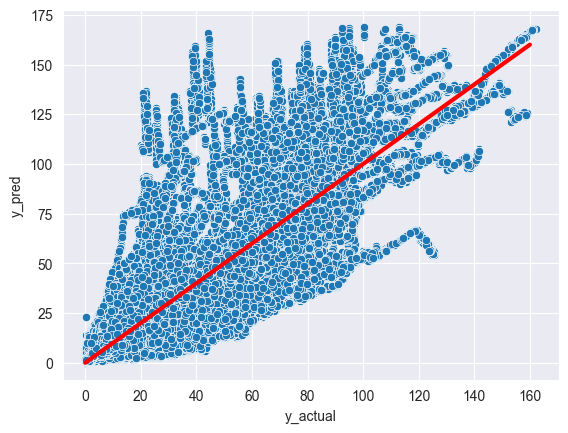

In [6]:
display_df = pd.DataFrame({
    'y_actual': y_actual,
    'y_pred': y_pred
})

# die Daten mischen, da das Streudiagramm die Punkte in der richtigen Reihenfolge ausgibt
# Mischen macht die Daten besser erkennbar
display_df = display_df.sample(frac=1)

sns.scatterplot(x=display_df['y_actual'], y=display_df['y_pred'])
# Referenzgerade mit Steigung 1 hizufügen
plt.plot([0, 160], [0, 160], color='red', lw=3)